In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from itertools import chain
# from convection_param.ConvParamFuncs import *
from convection_param.GetTrainingData import read_coarse_data
from tqdm.auto import tqdm
import datetime
import time
from pprint import pprint
from sklearn.decomposition import PCA
import pandas as pd
import os
from convection_param.HelperFuncs import assign_bnd_coords, create_data_array, reorder_output, get_flattened_idx, unique_unsorted
import pickle
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

xr.set_options(display_style="html");
%load_ext autoreload
%autoreload 2

In [7]:
vars_to_exclude = ['tke_fl','theta_v','rho','pres','temp']
X_vars =   ['w_fl','qv','qc','qi','qr','qs','u','v','h','cell','clat','clon']
X3d_vars = ['w_fl','qv','qc','qi','qr','qs','u','v','h']

Y_vars = ['subg_flux_qv','subg_flux_qc','subg_flux_qi','subg_flux_qr','subg_flux_qs','subg_flux_h','subg_flux_u','subg_flux_v','clt','cltp','liq_detri','ice_detri','tot_prec']
Y3d_vars = ['subg_flux_qv','subg_flux_qc','subg_flux_qi','subg_flux_qr','subg_flux_qs','subg_flux_h','subg_flux_u','subg_flux_v']
Y3d_vars_units = ['kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','J m-2 s-1','kg m-1 s-2','kg m-1 s-2']

npr.seed(312)
target_format = 'seq'

This notebook reads in coarse grained data and preprocesses it further (splitting/standardization)

In [8]:
# # Method 1: If coarse grained files are available produced by the preprocessing pipeline


# dates = sorted([d.name for d in os.scandir('../Processed/') if ('2013' in d.name or '2016' in d.name) and d.is_dir()])
# print(dates)

# vars_to_exclude = ['tke_fl','theta_v','rho','pres','temp']
# X_vars =   ['w_fl','qv','qc','qi','qr','qs','u','v','h','cell','clat','clon']
# X3d_vars = ['w_fl','qv','qc','qi','qr','qs','u','v','h']

# Y_vars = ['subg_flux_qv','subg_flux_qc','subg_flux_qi','subg_flux_qr','subg_flux_qs','subg_flux_h','subg_flux_u','subg_flux_v','clt','cltp','liq_detri','ice_detri','tot_prec']
# Y3d_vars = ['subg_flux_qv','subg_flux_qc','subg_flux_qi','subg_flux_qr','subg_flux_qs','subg_flux_h','subg_flux_u','subg_flux_v']
# Y3d_vars_units = ['kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','kg m-2 s-1','J m-2 s-1','kg m-1 s-2','kg m-1 s-2']

# npr.seed(312)
# target_format = 'seq'

# dates = sorted([d.name for d in os.scandir('../Processed/') if ('2013' in d.name or '2016' in d.name) and d.is_dir()])
# print(dates)

# X_all = []
# Y_all = []
# c_threshold = 1
# unconv_frac = 0.1
# time_av = 1
# vert_coarse = True
# return_fluxes = 1
# conv_preprocessing = True

# for date in tqdm(dates):
#     if vert_coarse:
#         path = f'../Processed/{date}/ParamPrep/LowRes/R02B05/VertCoarse'
#     else:
#         path = f'../Processed/{date}/ParamPrep/LowRes/R02B05'

#     X_all_new, Y_all_new, X_expl, Y_expl = read_coarse_data(path, target_format, X_vars, Y_vars,
#                                                             conv_col_threshold=c_threshold,
#                                                             unconv_frac=unconv_frac,
#                                                             time_av=time_av,
#                                                             return_fluxes=return_fluxes)
#     print(X_all_new.shape)
#     print(Y_all_new.shape)
#     X_all.append(X_all_new)
#     Y_all.append(Y_all_new)

# X_all = np.concatenate(X_all, axis=0)
# Y_all = np.concatenate(Y_all, axis=0)
# print('All data:')
# print(X_all.shape)
# print(Y_all.shape)

# now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# np.savez(f'../local_data/narval_preprocessed/{now}-data_all_fromProcessedAllVars5d',
#          X_all=X_all,
#          Y_all=Y_all,
#          X_expl=X_expl,
#          Y_expl=Y_expl)

In [9]:
# Method 2: If coarse grained files are not available

file = np.load('../local_data/narval_preprocessed/20230208-101207-data_sample.npz')
print(file.files)
X_all, Y_all, X_expl, Y_expl = file['X_all'], file['Y_all'], file['X_expl'], file['Y_expl']

['X_all', 'Y_all', 'X_expl', 'Y_expl']


In [10]:
Y_expl = [[e[0], str(e[1])] for e in Y_expl]
X_expl = [[e[0], str(e[1])] for e in X_expl]

In [11]:
print('X_all shape before: ', X_all.shape)
# vars_to_exclude = ['tke_fl', 'pres', 'temp', 'theta_v', 'w_fl', 'rho', 'qv', 'u']
# vars_to_exclude = ['tke_fl','theta_v','rho','pres','temp']
vars_to_exclude = ['qr','qs']
X_vars = [var for var in X_vars if var not in vars_to_exclude]
X3d_vars = [var for var in X3d_vars if var not in vars_to_exclude]

def exclude_vars(data, expl, exclude_list):
    for var in exclude_list:
        idx0, idx1 = get_flattened_idx(expl, var)
        mask = np.full(len(expl),True)
        mask[idx0:idx1] = False
        expl = [x for x,keep in zip(expl, mask) if keep] # list(np.array(expl)[mask]) #expl[:idx0]+expl[idx1:]
        data = data[:,mask]
    
    return data, expl

X_all, X_expl = exclude_vars(X_all, X_expl, vars_to_exclude)
print('X_all shape after: ', X_all.shape)

X_all shape before:  (49800, 282)
X_all shape after:  (49800, 220)


In [12]:
X_all, Y_all, X_expl, Y_expl = reorder_output(X_all, Y_all, X_expl, Y_expl, X_vars, Y_vars)
all_coords = X_all[:,-3:]
X_all = X_all[:,:-3]
X_expl = X_expl[:-3]
# X_all = np.roll(X_all, 1, axis=1)
# Y_all = np.roll(Y_all, 1, axis=1)

['w_fl' 'qv' 'qc' 'qi' 'u' 'v' 'h' 'cell' 'clat' 'clon']
['subg_flux_qv' 'subg_flux_qc' 'subg_flux_qi' 'subg_flux_qr'
 'subg_flux_qs' 'subg_flux_h' 'subg_flux_u' 'subg_flux_v' 'clt' 'cltp'
 'liq_detri' 'ice_detri' 'tot_prec']
Data is already in order of X_vars / Y_vars


In [13]:
# Rescaling of precip. data
from convection_param.HelperFuncs import precip_rescaling, inv_precip_rescaling

prec_idx = list(map(''.join, Y_expl)).index('tot_prec0')

# plt.hist(Y_all[:,prec_idx], bins=50, log=True)
# plt.xlabel('Precip. / kg m-2')
# plt.figure()
# plt.hist(inv_precip_rescaling(scalerdict_Y['tot_prec'].inverse_transform(scalerdict_Y['tot_prec'].transform(precip_rescaling(Y_all[:,prec_idx], eps=1))), eps=1), bins=50, log=True)
# plt.xlabel('Precip. rescaled')
# plt.show()
Y_all[:,prec_idx] = precip_rescaling(Y_all[:,prec_idx], eps=1)

#### Prepare data for NN

In [30]:
def filter_lvls(data, variables, var_expl, lvls):
    to_drop = [(var, str(lvl)) for var in variables for lvl in lvls]
    print(to_drop)

    df = pd.DataFrame(data.T)
    df.index = pd.MultiIndex.from_tuples(var_expl, names=['variable', 'level'])
    df = df.drop(index=to_drop)
    df = df.T
    # var_expl = [expl for expl in var_expl if expl not in [list(e) for e in to_drop]]
    var_expl = [expl for expl in var_expl if expl not in map(list, to_drop)]
    return df.values, var_expl

In [31]:
if vert_coarse:
    exclude_lvls = np.load('../local_data/exclude_lvls_th.0001_DOM01.npz')['exclude_lvls_lr']
else:
    exclude_lvls = np.load('../local_data/exclude_lvls_th.0001_DOM01.npz')['exclude_lvls']

X_all, X_expl = filter_lvls(X_all, X3d_vars, X_expl, exclude_lvls)
Y_all, Y_expl = filter_lvls(Y_all, Y3d_vars, Y_expl, exclude_lvls)

exclude_idx = exclude_lvls-1
print('X_all shape: ', X_all.shape)
print('Y_all shape: ', Y_all.shape)

[('w_fl', '1'), ('w_fl', '2'), ('w_fl', '3'), ('w_fl', '4'), ('w_fl', '5'), ('w_fl', '6'), ('w_fl', '7'), ('w_fl', '8'), ('qv', '1'), ('qv', '2'), ('qv', '3'), ('qv', '4'), ('qv', '5'), ('qv', '6'), ('qv', '7'), ('qv', '8'), ('qc', '1'), ('qc', '2'), ('qc', '3'), ('qc', '4'), ('qc', '5'), ('qc', '6'), ('qc', '7'), ('qc', '8'), ('qi', '1'), ('qi', '2'), ('qi', '3'), ('qi', '4'), ('qi', '5'), ('qi', '6'), ('qi', '7'), ('qi', '8'), ('u', '1'), ('u', '2'), ('u', '3'), ('u', '4'), ('u', '5'), ('u', '6'), ('u', '7'), ('u', '8'), ('v', '1'), ('v', '2'), ('v', '3'), ('v', '4'), ('v', '5'), ('v', '6'), ('v', '7'), ('v', '8'), ('h', '1'), ('h', '2'), ('h', '3'), ('h', '4'), ('h', '5'), ('h', '6'), ('h', '7'), ('h', '8')]
[('subg_flux_qv', '1'), ('subg_flux_qv', '2'), ('subg_flux_qv', '3'), ('subg_flux_qv', '4'), ('subg_flux_qv', '5'), ('subg_flux_qv', '6'), ('subg_flux_qv', '7'), ('subg_flux_qv', '8'), ('subg_flux_qc', '1'), ('subg_flux_qc', '2'), ('subg_flux_qc', '3'), ('subg_flux_qc', '4'), ('

In [32]:
# flux correlation

In [33]:
X_all3d = X_all.reshape(X_all.shape[0], -1, 23)
X_expl3d = np.array(['_'.join(s) for s in X_expl[:]]).reshape(-1, 23)

In [34]:
display(X_expl3d[1])
display(X_expl3d[2])

array(['qv_9', 'qv_10', 'qv_11', 'qv_12', 'qv_13', 'qv_14', 'qv_15',
       'qv_16', 'qv_17', 'qv_18', 'qv_19', 'qv_20', 'qv_21', 'qv_22',
       'qv_23', 'qv_24', 'qv_25', 'qv_26', 'qv_27', 'qv_28', 'qv_29',
       'qv_30', 'qv_31'], dtype='<U7')

array(['qc_9', 'qc_10', 'qc_11', 'qc_12', 'qc_13', 'qc_14', 'qc_15',
       'qc_16', 'qc_17', 'qc_18', 'qc_19', 'qc_20', 'qc_21', 'qc_22',
       'qc_23', 'qc_24', 'qc_25', 'qc_26', 'qc_27', 'qc_28', 'qc_29',
       'qc_30', 'qc_31'], dtype='<U7')

In [35]:
X_all3d.shape

(2017020, 7, 23)

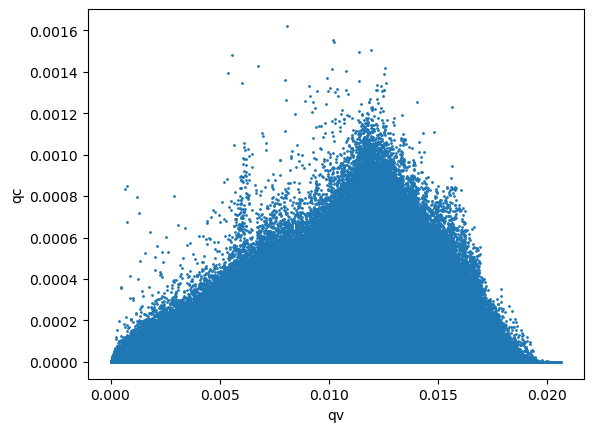

In [36]:
idx = np.s_[:]

qv_all = X_all3d[:,1,:].ravel()
qc_all = X_all3d[:,2,:].ravel()

plt.plot(qv_all[idx], qc_all[idx], 'o', ms=1)
plt.xlabel('qv')
plt.ylabel('qc')

plt.show()

In [37]:
print(np.corrcoef(qv_all, qc_all)[0,1])
print('---------------')
for i in range(23):
    print(np.corrcoef(X_all3d[:,1,i], X_all3d[:,2,i])[0,1])

0.2445376834280752
---------------
0.016525335080371396
0.030386419222781104
0.017476692952670653
0.1198780862227468
0.1343158479387711
0.17116345322810236
0.21828724203896474
0.2932924366189473
0.43549010631196855
0.49422312981706007
0.46722826005528656
0.4461191991661966
0.46149915947188797
0.47399902223321977
0.44920328405750254
0.3419914321753207
0.1446968621245918
-0.00830502434850103
0.03167525773342699
0.05910977354182689
0.01333744386451438
-0.013401436419583107
-0.026400091122881466


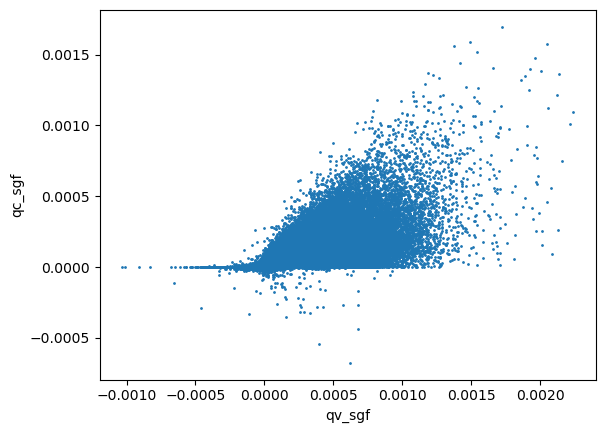

In [38]:
Y_all3d = Y_all[:,:-5].reshape(Y_all.shape[0], 8, 23)
Y_expl3d = np.array(['_'.join(s) for s in Y_expl[:-5]]).reshape(8, 23)
qv_sgf_all = Y_all3d[:,0,:].ravel()
qc_sgf_all = Y_all3d[:,1,:].ravel()

plt.plot(qv_sgf_all[idx], qc_sgf_all[idx], 'o', ms=1)
plt.xlabel('qv_sgf')
plt.ylabel('qc_sgf')

plt.show()

In [39]:
print(np.corrcoef(qv_sgf_all, qc_sgf_all)[0,1])
print('---------------')
for i in range(23):
    print(np.corrcoef(Y_all3d[:,0,i], Y_all3d[:,1,i])[0,1])

0.8241041343491231
---------------
0.08033039919299942
0.089792195886885
0.21534311568975129
0.8059616106338616
0.8483888663342729
0.8653058111455721
0.8851225078141097
0.8964769413161807
0.8907997614896032
0.8756380139464474
0.8719596462497783
0.874498924676526
0.863147756802984
0.8610220089238756
0.8453313244742253
0.8085238965730885
0.743877269485166
0.6626596921719864
0.5946667551139513
0.5340089145388477
0.36396899469644245
0.34657013146447163
0.3836172349588655


In [40]:
# end flux correlation

In [41]:
X_all_std = np.std(X_all, axis=0)
X_zero_std_mask = np.isclose(X_all_std,0)
X_zero_std_idx = np.where(X_zero_std_mask)[0]
X_const_vars = [X_expl[i] for i in X_zero_std_idx]
print(f'Variables (n={X_zero_std_mask.sum()}) with constant values and therefore no predictive power:\n', X_const_vars)

Variables (n=15) with constant values and therefore no predictive power:
 [['qc', '9'], ['qc', '10'], ['qc', '11'], ['qi', '20'], ['qi', '21'], ['qi', '22'], ['qi', '23'], ['qi', '24'], ['qi', '25'], ['qi', '26'], ['qi', '27'], ['qi', '28'], ['qi', '29'], ['qi', '30'], ['qi', '31']]


In [42]:
Y_all_mean = np.mean(Y_all, axis=0)
Y_all_std = np.std(Y_all, axis=0)
Y_zero_std_mask = np.isclose(Y_all_std,0)#,atol=1e-30)
Y_zero_std_idx = np.where(Y_zero_std_mask)[0]
Y_nonzero_std_idx = np.where(~Y_zero_std_mask)[0]
Y_const_vars = [Y_expl[i] for i in Y_zero_std_idx]
print(f'(n={Y_zero_std_mask.sum()}) Y variables with constant values:\n{Y_const_vars}')

(n=28) Y variables with constant values:
[['subg_flux_qc', '9'], ['subg_flux_qc', '10'], ['subg_flux_qc', '11'], ['subg_flux_qi', '19'], ['subg_flux_qi', '20'], ['subg_flux_qi', '21'], ['subg_flux_qi', '22'], ['subg_flux_qi', '23'], ['subg_flux_qi', '24'], ['subg_flux_qi', '25'], ['subg_flux_qi', '26'], ['subg_flux_qi', '27'], ['subg_flux_qi', '28'], ['subg_flux_qi', '29'], ['subg_flux_qi', '30'], ['subg_flux_qi', '31'], ['subg_flux_qr', '9'], ['subg_flux_qr', '10'], ['subg_flux_qr', '11'], ['subg_flux_qs', '23'], ['subg_flux_qs', '24'], ['subg_flux_qs', '25'], ['subg_flux_qs', '26'], ['subg_flux_qs', '27'], ['subg_flux_qs', '28'], ['subg_flux_qs', '29'], ['subg_flux_qs', '30'], ['subg_flux_qs', '31']]


In [43]:
# Y_orig_all = Y_all.copy()
if not conv_preprocessing:
    X_expl = [expl for expl in X_expl if not expl in X_const_vars]
    Y_expl = [expl for expl in Y_expl if not expl in Y_const_vars]
    
    X_all = X_all[:,~X_zero_std_mask]
    Y_all = Y_all[:,~Y_zero_std_mask]

In [45]:
from convection_param.Constants import label_remapping

Y3d_var_mask = {}
Y_mask = np.ones(Y_all.shape[-1]).astype(bool)
for Y_var in Y3d_vars:
    Y3d_var_mask[Y_var] = np.array([Y_var == expl[0] for expl in Y_expl])

for i,(Y_var,mask) in enumerate(Y3d_var_mask.items()):
    quantiles = np.quantile(np.abs(Y_all[:,mask]), 0.99, axis=0)
    threshold = 0.01*quantiles.max()
    threshold_mask = quantiles > threshold
    Y_mask[mask] = threshold_mask
    
    # plt.figure(constrained_layout=True)
    # # plt.bar(range(9,32), np.mean(Y_all[:,mask], axis=0))
    # used_colors = np.array(['#df1c26', '#28e787'])
    # plt.bar(range(9,32), quantiles)#, color=used_colors[threshold_mask.astype(int)])
    # # plt.axhline(threshold)
    # plt.scatter(range(9,32), [threshold for _ in range(9,32)], c=used_colors[threshold_mask.astype(int)], marker='_', s=20)
    # plt.xlabel('level')
    # plt.ylabel(f'0.99\'th quantile |{label_remapping[Y_var]}| / {Y3d_vars_units[i]}')
    # plt.title(f'{label_remapping[Y_var]}')
    # plt.savefig(f'Figures/VarThresholdingDistributions/{Y_var}_alldays.jpg', dpi=200)

# plt.show()
    
# for a,b in zip(Y_expl, Y_mask):
#     print(a,b)

In [46]:
Y_all3d = Y_all[:,:-5].reshape(Y_all.shape[0], 8, 23)
Y_expl3d = np.array(['_'.join(s) for s in Y_expl[:-5]]).reshape(8, 23)

In [47]:
# mean_fluxes = np.empty((8,23))
# for i in range(8):
#     for j in range(23):
#         mean_flux = Y_all3d[:,i,j].mean()
#         mean_fluxes[i,j] = mean_flux
#         # var = Y_expl3d[i,j]
#         # print(f'Mean flux for var {var}: {mean_flux}')
# mean_fluxes = np.quantile(Y_all3d, 0.1, axis=0)
mean_fluxes = np.mean(Y_all3d, axis=0)
mean_fluxes = mean_fluxes.T
mean_fluxes /= np.max(np.abs(mean_fluxes), axis=0)

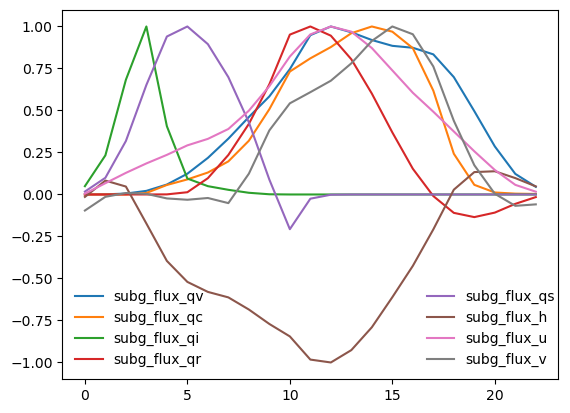

In [48]:
Y_variables = np.array([e[0] for e in Y_expl[:-5]])
Y_variables_unique = unique_unsorted(Y_variables)

plt.plot(mean_fluxes, label=Y_variables_unique)
plt.legend(frameon=False, columnspacing=16, ncol=2)
# plt.savefig(f'Figures/VerticalMeanFluxProfiles.jpg', dpi=300)
plt.show()

In [49]:
print(X_all3d.shape)
mean_vars = np.mean(X_all3d, axis=0)
print(mean_vars.shape)
mean_vars = mean_vars.T
mean_vars /= np.max(np.abs(mean_vars), axis=0)

(2017020, 7, 23)
(7, 23)


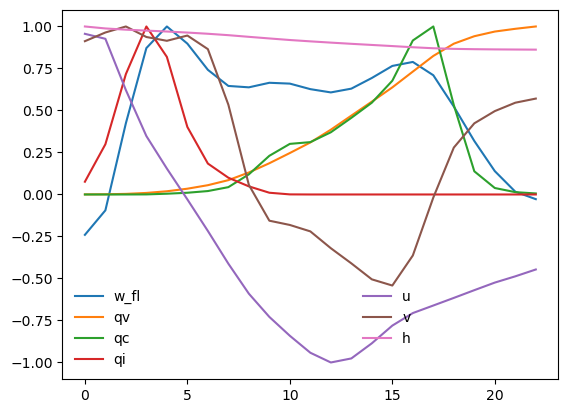

In [50]:
X_variables = np.array([e[0] for e in X_expl[:]])
X_variables_unique = unique_unsorted(X_variables)

plt.plot(mean_vars, label=X_variables_unique)
plt.legend(ncol=2, frameon=False, columnspacing=16)
# plt.savefig(f'Figures/VerticalMeanFluxProfiles.jpg', dpi=300)
plt.show()

In [38]:
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
data_name = '20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct_woqrqs'
# data_name = now + '-R2B5_y13y16_vcg-fluxes_rho_fluct_3days'
# # Apply mask
# Y_all = Y_all[:,Y_mask]
# Y_expl = [expl for flag,expl in zip(Y_mask,Y_expl) if flag]
# Save mask
file = f'../local_data/TrainData/{data_name}_Ymask.pickle'
with open(file, 'wb') as handle:
    pickle.dump(Y_mask, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

train_ratio = 0.8#0.75
val_ratio = (1-train_ratio)/2
test_ratio = val_ratio
# val_ratio = 0.1#0.15
# test_ratio = 0.1

npr.seed(45782)
train_idx, test_idx = train_test_split(np.arange(X_all.shape[0]), test_size=1-train_ratio)
val_idx, test_idx = train_test_split(test_idx, test_size=test_ratio/(test_ratio+val_ratio))
X_train, X_val, X_test = X_all[train_idx], X_all[val_idx], X_all[test_idx]
Y_train, Y_val, Y_test = Y_all[train_idx], Y_all[val_idx], Y_all[test_idx]
train_coords, val_coords, test_coords = all_coords[train_idx], all_coords[val_idx], all_coords[test_idx]

print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: (1613616, 161)
Y_train shape: (1613616, 189)
X_val shape: (201702, 161)
Y_val shape: (201702, 189)
X_test shape: (201702, 161)
Y_test shape: (201702, 189)


In [40]:
from convection_param.HelperFuncs import StandardScalerOneVar

def normalize_across_channels(train, val, test, expl_vars):
    scalers = {}
    idx0 = 0
    for var, idx_range in zip(*unique_unsorted(expl_vars, return_counts=True)):
        scaler = StandardScalerOneVar()
        # print(idx0, idx0+idx_range)
        scaler.fit(train[...,idx0:idx0+idx_range])
        train[...,idx0:idx0+idx_range] = scaler.transform(train[...,idx0:idx0+idx_range])
        val[...,idx0:idx0+idx_range] = scaler.transform(val[...,idx0:idx0+idx_range])
        test[...,idx0:idx0+idx_range] = scaler.transform(test[...,idx0:idx0+idx_range])
        # plt.figure()
        # plt.scatter(range(idx_range), train[...,idx0:idx0+idx_range].mean(axis=0))
        # plt.title(var)
        idx0 += idx_range
        scalers[var] = scaler
    return train, val, test, scalers
        
X_expl_vars = [expl[0] for expl in X_expl]
Y_expl_vars = [expl[0] for expl in Y_expl]
X_train, X_val, X_test, scalerdict_X = normalize_across_channels(X_train, X_val, X_test, X_expl_vars)
Y_train, Y_val, Y_test, scalerdict_Y = normalize_across_channels(Y_train, Y_val, Y_test, Y_expl_vars)
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: (1613616, 161)
Y_train shape: (1613616, 189)
X_val shape: (201702, 161)
Y_val shape: (201702, 189)
X_test shape: (201702, 161)
Y_test shape: (201702, 189)


In [1]:
!ls ../local_data

20230112-160555-data_all.npz
20230112-162305-data_all.npz
20230112-164218-data_all.npz
20230113-101603-data_all.npz
20230208-101207-data_all.npz
20230210-131632-data_all_fromProcessedRhoFluctNeglectMerged.npz
20230216-161056-data_all_fromProcessedAllVars.npz
20230216-163338-data_all_fromProcessedAllVars5d.npz
7days_data_ct1_uf0.1.npz
Animations
exclude_lvls_th.0001_DOM01.npz
Figures
in_files0825.txt
in_files0830.txt
in_files_high_res.txt
in_files.txt
slurm_test.sh
tensorflow_datasets
TestPredictions
TrainData


In [41]:
with open(f'../local_data/TrainData/{data_name}_scalerdict_X.pickle', 'wb') as handle:
    pickle.dump(scalerdict_X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'../local_data/TrainData/{data_name}_scalerdict_Y.pickle', 'wb') as handle:
    pickle.dump(scalerdict_Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Split in channels for convolutions

In [44]:
if conv_preprocessing:
    # Assert that all variables are "behind" each, otherwise reshaping does not make sense
    variables = np.array([e[0] for e in X_expl])
    variables_unique = unique_unsorted(variables)
    print(variables_unique)
    for var in variables_unique:
        assert np.all(np.diff(np.nonzero(variables == var)[0]) == 1)

    X_train = X_train.reshape(len(train_idx), len(variables_unique), -1)
    X_val = X_val.reshape(len(val_idx), len(variables_unique), -1)
    X_test = X_test.reshape(len(test_idx), len(variables_unique), -1)
    X_train = np.swapaxes(X_train, 1, 2)
    X_val = np.swapaxes(X_val, 1, 2)
    X_test = np.swapaxes(X_test, 1, 2)

    print(f'X_train shape: {X_train.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'X_test shape: {X_test.shape}')

['w_fl' 'qv' 'qc' 'qi' 'u' 'v' 'h']
X_train shape: (1613616, 23, 7)
X_val shape: (201702, 23, 7)
X_test shape: (201702, 23, 7)


In [48]:
if False:
    # Assert that all variables are "behind" each, otherwise reshaping does not make sense
    variables = np.array([e[0] for e in Y_expl])
    mask3d = np.array([e[0] in Y3d_vars for e in Y_expl])
    variables3d = variables[mask3d]
    # variables2d = variables[~mask3d]
    variables3d_unique = np.unique(variables3d)
    print(variables3d_unique)
    # variables2d_unique = np.unique(variables2d)
    for var in variables3d_unique:
        assert np.all(np.diff(np.nonzero(variables3d == var)[0]) == 1)

    Y3d_train = Y_train[:,mask3d].reshape(len(train_idx), len(variables3d_unique), -1)
    Y3d_val = Y_val[:,mask3d].reshape(len(val_idx), len(variables3d_unique), -1)
    Y3d_test = Y_test[:,mask3d].reshape(len(test_idx), len(variables3d_unique), -1)
    Y3d_train = np.swapaxes(Y3d_train, 1, 2)
    Y3d_val = np.swapaxes(Y3d_val, 1, 2)
    Y3d_test = np.swapaxes(Y3d_test, 1, 2)

    Y2d_train = Y_train[:,~mask3d]
    Y2d_val = Y_val[:,~mask3d]
    Y2d_test = Y_test[:,~mask3d]

    print(f'Y3d_train shape: {Y3d_train.shape}')
    print(f'Y3d_val shape: {Y3d_val.shape}')
    print(f'Y3d_test shape: {Y3d_test.shape}')
    print(f'Y2d_train shape: {Y2d_train.shape}')
    print(f'Y2d_val shape: {Y2d_val.shape}')
    print(f'Y2d_test shape: {Y2d_test.shape}')

    # Change 2d shapes to 3d shape for concatenation with 3d data
    Y2d_train = np.repeat(Y2d_train[:, np.newaxis, :], 23, axis=1)
    Y2d_val = np.repeat(Y2d_val[:, np.newaxis, :], 23, axis=1)
    Y2d_test = np.repeat(Y2d_test[:, np.newaxis, :], 23, axis=1)
    # Concatenate 2d and 3d data
    Y_train = np.concatenate([Y3d_train, Y2d_train], axis=-1)
    Y_val = np.concatenate([Y3d_val, Y2d_val], axis=-1)
    Y_test = np.concatenate([Y3d_test, Y2d_test], axis=-1)

    print('-----------------')
    print(f'Y_train shape: {Y_train.shape}')
    print(f'Y_val shape: {Y_val.shape}')
    print(f'Y_test shape: {Y_test.shape}')

In [49]:
print('-----------------')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_val shape: {Y_val.shape}')
print(f'Y_test shape: {Y_test.shape}')

-----------------
Y_train shape: (1613616, 189)
Y_val shape: (201702, 189)
Y_test shape: (201702, 189)


In [50]:
def Y3dto2d(Y):
    # Y - (samples, h, d)
    Y = np.swapaxes(Y, 1, 2)
    Y1 = Y[:,:6,:].reshape(Y.shape[0], -1)
    Y2 = np.mean(Y[:,6:,:], axis=2)
    # Y2 = np.roll(Y2, 1, axis=1)
    result =  np.concatenate([Y1,Y2],axis=-1)
    # result = np.roll(result, 4, axis=1)
    return result

In [51]:
np.savez(f'../local_data/TrainData/{data_name}',
         X_train=X_train,
         X_val=X_val,
         X_test=X_test,
         Y_train=Y_train,
         Y_val=Y_val,
         Y_test=Y_test,
         X_expl=X_expl,
         Y_expl=Y_expl,
         train_coords=train_coords,
         val_coords=val_coords,
         test_coords=test_coords)